In [29]:
# --- Essential Imports ---
import numpy as np
import random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scrublet as scr
import os
# --- Set reproducibility seed ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

#### Step 1: Load merged data into an AnnData object

In [6]:
#Load merged data
df = pd.read_csv("../data/merged_counts.csv", index_col=0)

In [7]:
#Step 2: Wrap it into AnnData
adata = sc.AnnData(df.drop(columns=["sample", "condition"]))
adata.obs["sample"] = df["sample"].values
adata.obs["condition"] = df["condition"].values

In [8]:
# Create Anndata folder under results
os.makedirs("../results/anndata", exist_ok=True)

In [12]:
#Step 3: Save to .h5ad for fast reload later
adata.write("../results/anndata/qc_unfiltered.h5ad")

In [ ]:
#Saved compressed version
#adata.write("../results/anndata/qc_unfiltered.h5ad", compression="gzip")

In [14]:
#Reload the saved h5ad data
#Load using memory-efficient mode
adata = sc.read_h5ad("../results/anndata/qc_unfiltered.h5ad", backed="r")

In [15]:
#Check AnnData summary
print(adata)

AnnData object with n_obs × n_vars = 68710 × 34546 backed at '..\\results\\anndata\\qc_unfiltered.h5ad'
    obs: 'sample', 'condition'


In [17]:
#View per-cell metadata (sample, condition)
adata.obs.head()

,sample,condition
TAGGTACCATGGCCAC-1_1,GSM5226574_C51ctr,Control
ATTCACTGTAACAGGC-1_1,GSM5226574_C51ctr,Control
TAACTTCCAACCACGC-1_1,GSM5226574_C51ctr,Control
TTGGGTACACGACAAG-1_1,GSM5226574_C51ctr,Control
AGGCCACAGAGTCACG-1_1,GSM5226574_C51ctr,Control


In [18]:
#View per-gene metadata (mt, ribo flags)
adata.var.head()

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409


In [19]:
#View shape of raw expression matrix
adata.X.shape

(68710, 34546)

In [23]:
#View sparse expression matrix
print(adata.X[:5, :5])

[[0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [25]:
#view condition distribution
adata.obs["condition"].value_counts()

condition
Control    36678
COVID      32032
Name: count, dtype: int64

In [26]:
#view sample distribution
adata.obs["sample"].value_counts()

sample
GSM5226586_L06cov         7582
GSM5226576_C53ctr         7120
GSM5226574_C51ctr         6099
GSM5226578_C55ctr         5685
GSM5226587_L07cov         5074
GSM5226582_L03cov         5060
GSM5226580_C57ctr         4789
GSM5226584_L04covaddon    4574
GSM5226575_C52ctr         4513
GSM5226577_C54ctr         4382
GSM5226579_C56ctr         4090
GSM5226583_L04cov         3630
GSM5226581_L01cov         3060
GSM5226585_L05cov         3052
Name: count, dtype: int64

In [28]:
#adata to memory()
adata = adata.to_memory()

#### Step 2 — Quality Control (QC)

In [30]:
#2.1: Flag Mitochondrial and Ribosomal Genes
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPL", "RPS"))

Mitochondrial genes (MT-) and ribosomal proteins (RPL, RPS) are QC markers.
High expression of mitochondrial genes often indicates stressed or dying cells.
Ribosomal gene overexpression can indicate poor capture efficiency or technical noise.

In [31]:
#Inspect the sum of the flags:
adata.var[["mt", "ribo"]].sum()

mt       13
ribo    102
dtype: int64

In [32]:
#2.2: Compute Per-Cell QC Metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True
)

Stores the following in adata.obs:
1. total_counts: Total number of UMIs (reads) per cell (i.e Sum of all gene counts (UMIs) per cell.).
2. n_genes_by_counts: Number of genes expressed per cell.
3. pct_counts_mt: Percentage of counts from mitochondrial genes.
4. pct_counts_ribo: Percentage from ribosomal genes.

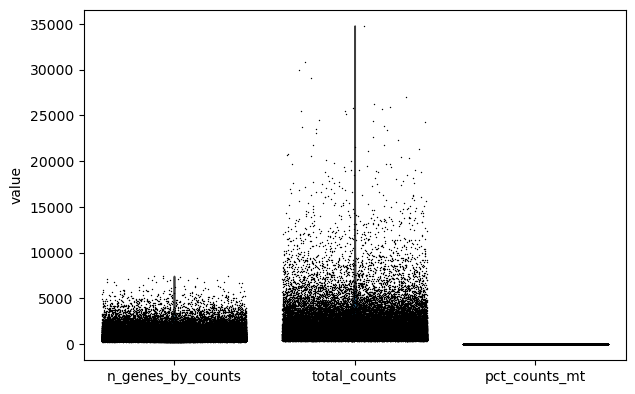

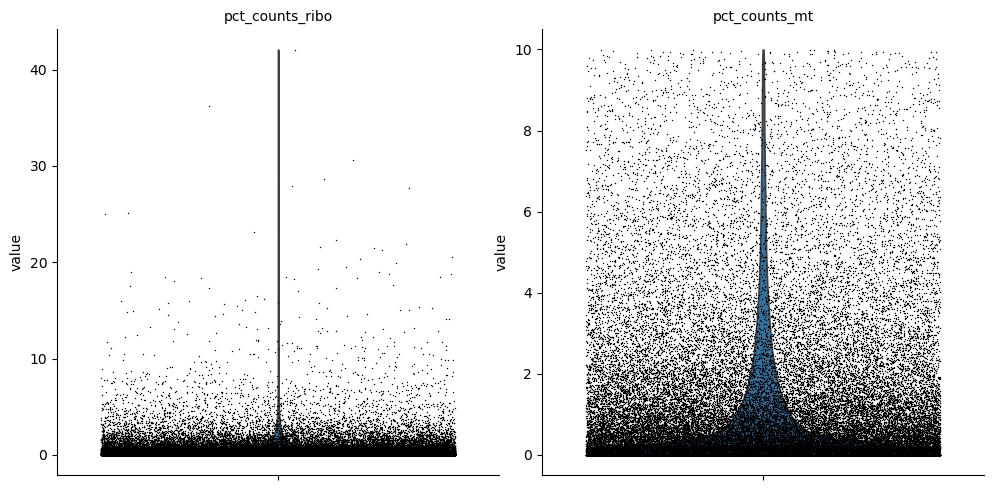

In [33]:
#2.3: Visualize Distributions for Filtering
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4)
sc.pl.violin(adata, ["pct_counts_ribo", "pct_counts_mt"], jitter=0.4, multi_panel=True)

Identify thresholds for low-quality cells visually.
1. Cells with very few genes (empty droplets).
2. Cells with high MT% (dying cells).
3. High ribosomal % (likely noise).

#### Quality Control: Choosing Filtering Metrics

To ensure high-quality single-cell data, we examine key per-cell QC metrics:

- **n_genes_by_counts**: Number of genes detected per cell.  
  - Low values (<200) may indicate **empty droplets** or dead cells.
  - Most healthy cells fall between **500–3000 genes**.

- **total_counts**: Total UMI counts per cell.  
  - Extremely high values (>20,000–35,000) may indicate **doublets** or overly captured cells.

- **pct_counts_mt**: Percent of reads from mitochondrial genes.  
  - High mitochondrial content (>5%) often reflects **stressed or dying cells**.

- **pct_counts_ribo**: Percent of reads from ribosomal protein genes.  
  - High ribosomal expression (>60%) may signal **technical noise** or **low-complexity libraries**.
  - Most high-quality cells show <10–20% ribosomal content.

We apply the following filtering criteria based on these distributions:

```python
# Apply standard filtering thresholds
 min_genes=200      # Drop low-content cells
 min_cells=3        # Drop genes rarely expressed
"pct_counts_mt"] < 5  # Remove high-mito cells
"pct_counts_ribo"] < 60 # Remove ribosomal outliers


In [34]:
# 2.4: Filter Low-Quality Cells and Genes
# Remove cells with fewer than 200 detected genes (likely dead cells or empty droplets).
sc.pp.filter_cells(adata, min_genes=200)

In [35]:
# Remove genes detected in fewer than 3 cells (likely noise or uninformative).
sc.pp.filter_genes(adata, min_cells=3)

In [36]:
# Filter out cells with >5% mitochondrial gene expression (indicative of damaged cells).
adata = adata[adata.obs["pct_counts_mt"] < 5, :]

In [37]:
# Filter out cells with >60% ribosomal gene expression (potential technical artifacts or stress).
adata = adata[adata.obs["pct_counts_ribo"] < 60, :]

In [38]:
# Save filtered AnnData object
adata.write("../results/anndata/qc_filtered.h5ad")

#### Step 3: Doublet Detection Using Scrublet

In [39]:
#Step 3: Doublet Detection Using Scrublet
#Doublets are artifacts where two cells are captured together and falsely treated as one.
# Convert sparse matrix to dense (Scrublet requires dense input)
counts_matrix = adata.X.toarray()

In [40]:
# Initialize Scrublet
scrub = scr.Scrublet(counts_matrix)

In [41]:
#Run doublet prediction
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 19.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.7%
Elapsed time: 817.3 seconds


In [42]:
#Store in AnnData
adata.obs["doublet_score"] = doublet_scores
adata.obs["predicted_doublet"] = predicted_doublets

C:\Users\nn\AppData\Local\Temp\ipykernel_5456\1885047497.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = doublet_scores


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

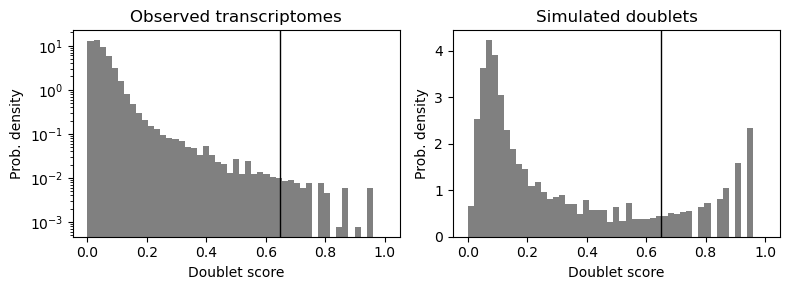

In [43]:
# Visualize histogram of scores
scrub.plot_histogram()

- **Detected doublet rate**: Actual flagged doublets among real cells (very low: 0.1%)
- **Estimated detectable doublet fraction**: What % of synthetic doublets Scrublet thinks it *could* detect. (19.7% is moderate)
- **Expected rate**: Typical experimental expectation (usually 5–10%)
- **Estimated rate**: Scrublet's final estimate (0.7%) — quite low, possibly due to:
  - Good sample quality
  - Tight cell populations
  - Conservative thresholding

In [44]:
# Filter out predicted doublets
adata = adata[~adata.obs["predicted_doublet"], :]

In [45]:
# Save the clean object
adata.write("../results/anndata/qc_nodoublets.h5ad")